<a href="https://colab.research.google.com/github/Raph-09/BOOK-RECOMMENDATION-SYSYTEM/blob/main/Book_Recommendation_system(collaborative_filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Import libraries needed for the project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

### Loading datasets

In [ ]:
books = pd.read_csv('/content/drive/MyDrive/datascience_file/BX-Books.csv',sep=';', error_bad_lines=False, encoding="latin-1")
ratings = pd.read_csv('/content/drive/MyDrive/datascience_file/BX-Book-Ratings.csv',sep=';', error_bad_lines=False, encoding="latin-1")
users = pd.read_csv('/content/drive/MyDrive/datascience_file/BX-Users.csv',sep=';', error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:27

## Exploratory Data Analysis

In [ ]:
print(books.columns)
print(ratings.columns)
print(users.columns)

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')
Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')
Index(['User-ID', 'Location', 'Age'], dtype='object')


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books = books.drop(['Book-Author', 'Year-Of-Publication', 'Publisher','Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1)

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
len(books), len(ratings), len(users)

(271360, 1149780, 278858)

In [ ]:
ratings['User-ID'].nunique(), users['User-ID'].nunique()

(105283, 278858)

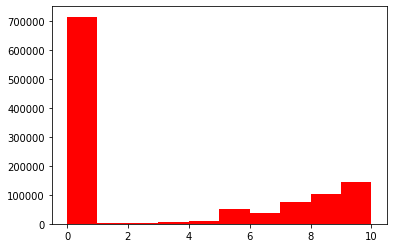

In [ ]:
  plt.hist(ratings['Book-Rating'],color='red')
  plt.show()

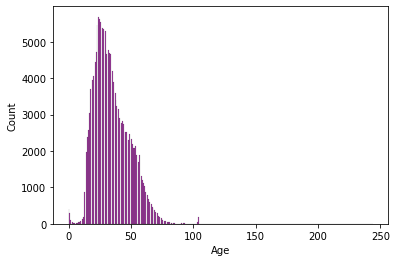

In [ ]:
sns.histplot(users['Age'],color='purple')
plt.show()

In [ ]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [ ]:
counts = ratings['User-ID'].value_counts()
users_count = counts[counts >= 100]
users_count.head(10)

11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
Name: User-ID, dtype: int64

In [ ]:
counts_2 = ratings['Book-Rating'].value_counts()
ratings_count = counts_2[counts_2>=500]
print(ratings_count)

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64


In [ ]:
ratings = ratings[ratings['User-ID'].isin(counts[counts >=100].index)]
ratings = ratings[ratings['Book-Rating'].isin(counts_2[counts_2 >= 100].index)]

In [ ]:
ratings.shape

(658805, 3)

In [ ]:
book_rating_merge = pd.merge(ratings, books, on='ISBN')

In [ ]:
book_rating_merge.head(2)

,User-ID,ISBN,Book-Rating,Book-Title
0,276925,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...


In [ ]:
book_rating_merge = book_rating_merge.dropna(axis=0,subset = ['Book-Title'])

In [ ]:
len(book_rating_merge)

606344

In [ ]:
book_ratingCount = (book_rating_merge.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().rename(columns = {'Book-Rating': 'Rating_Count'}))

In [ ]:
book_ratingCount.head()

,Book-Title,Rating_Count
0,A Light in the Storm: The Civil War Diary of ...,3
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [ ]:
total_rating = book_rating_merge.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
total_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Rating_Count
0,276925,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,105
1,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,105
2,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,105
3,10030,002542730X,7,Politically Correct Bedtime Stories: Modern Ta...,105
4,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,105


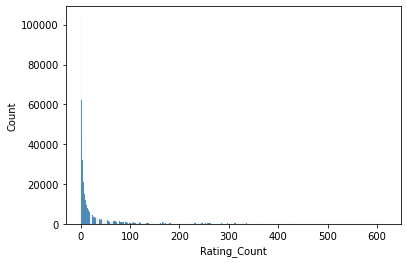

In [ ]:
sns.histplot(total_rating['Rating_Count'])
plt.show()

In [ ]:
count_r = total_rating['Rating_Count'].value_counts()
print(count_r.iloc[20:30])

21    4725
22    4708
23    4508
24    4416
27    4374
25    3925
26    3432
28    3388
29    3277
35    3150
Name: Rating_Count, dtype: int64


In [ ]:
threshold_var=20
rating_popular_book = total_rating.query('Rating_Count >= @threshold_var')
rating_popular_book.head()

,User-ID,ISBN,Book-Rating,Book-Title,Rating_Count
0,276925,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,105
1,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,105
2,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,105
3,10030,002542730X,7,Politically Correct Bedtime Stories: Modern Ta...,105
4,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,105


In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users = users.drop('Age',axis=1)

In [ ]:
users['Location'].unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

# Only users in United Kingdom

In [ ]:
books_users = rating_popular_book.merge(users, left_on = 'User-ID', right_on = 'User-ID', how = 'left')

UK_user_rating = books_users[books_users['Location'].str.contains("united kingdom")]
UK_user_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Rating_Count,Location
43,128696,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,105,"southampton, england, united kingdom"
77,209516,002542730X,9,Politically Correct Bedtime Stories: Modern Ta...,105,"felixstowe, suffolk, united kingdom"
89,244277,002542730X,8,Politically Correct Bedtime Stories: Modern Ta...,105,"inverness, scotland, united kingdom"
103,56271,0140327592,8,Matilda,79,"leeds, england, united kingdom"
104,107301,0140327592,0,Matilda,79,"west kensington, london, united kingdom"


## Preparing data for the algorithms


In [ ]:
UK_user_rating = UK_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
UK_user_rating_pivot = UK_user_rating.pivot(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
UK_user_rating_matrix = csr_matrix(UK_user_rating_pivot.values)

In [ ]:
UK_user_rating_pivot.head()

User-ID,7105,14387,23902,25533,30509,30712,33888,37567,38464,40647,44925,56271,56399,60797,61667,62895,63714,67079,72451,76626,79556,80555,81274,91203,92853,93147,100088,100782,107301,109783,110029,110746,114446,122881,124688,126296,128696,131099,131855,138073,...,163761,165806,166922,170073,170184,171986,174092,179826,180651,185308,187520,193560,194646,195116,204946,205383,208410,209516,213316,213915,217121,219951,223814,224646,225986,227276,228789,236655,236727,238864,244277,246156,246617,252827,261037,266866,269728,272225,273718,274004
Book-Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3001: The Final Odyssey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# KNN MODEL

In [ ]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute',n_neighbors=6)
model_knn.fit(UK_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                 radius=1.0)

In [ ]:
title = '4 Blondes'
r = UK_user_rating_pivot.loc[title]
r.head()

In [ ]:
distances, indices = model_knn.kneighbors(UK_user_rating_pivot.loc[title,:].values.reshape(1, -1), n_neighbors = 6)

## LET'S TEST OUR RECOMMENDATION SYSTEM

In [ ]:
def recommender(title):
   distances, indices = model_knn.kneighbors(UK_user_rating_pivot.loc[title,:].values.reshape(1, -1), n_neighbors = 6)
   for i in range(0, len(distances.flatten())):
    if i == 0:
        print('The following are the recommendations if you read "{0}":\n'.format(title))
    else:
        print('{0}: {1}'.format(i, UK_user_rating_pivot.index[indices.flatten()[i]]))


In [ ]:
recommender('2nd Chance')

The following are the recommendations if you read "2nd Chance":

1: Surfacing
2: Such Devoted Sisters
3: Sula
4: Summer Sisters
5: Stupid White Men ...and Other Sorry Excuses for the State of the Nation!
